# Plots for ALPIDE analysis

## Preliminary operations

### Paths

In [1]:
import os

USER_PATH = os.getcwd()
DATA_PATH = USER_PATH + "/data/ALPIDE/"
SAVE_PATH = USER_PATH + "/plots/ALPIDE/"

### Flags

In [2]:
UNZIP_DATA    = False
WAVE2NUMPY    = False
PLOT_WAVE     = False
PLOT_MAV_WAVE = False
REJECT_3SIGMA = False

### Load packages

In [3]:
import os
import ROOT
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bokeh.palettes as palette

Welcome to JupyROOT 6.22/02


In [4]:
from ROOT import TF1
from ROOT import TCanvas, TGraph, TGraphErrors

### Settings

In [5]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

In [6]:
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

<ipython-input-6-4c3d034b1475>:1: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\boldmath']


In [7]:
col = palette.brewer['RdYlGn'][10]

### Constants

In [8]:
MIN_MV   = 2400
MAX_MV   = 3500
BKG_RATE = 0.2951674822029528 #6.635    # ev/h

### Functions

In [9]:
def moving_average(x, M):
    return np.convolve(x, np.ones(M), 'valid') / M

## Beam profile plots

### Load data

#### Experimental data

In [10]:
df_exp = pd.read_csv(DATA_PATH + "ALPIDE_data_profile.csv")

#### Simulated data: load

In [11]:
df_sim = np.loadtxt(DATA_PATH + "ALPIDE_beam_profile.txt")

#### Simulated data: shift correction

In [12]:
shift       = np.average(df_exp["ALPIDE_step"], weights=df_exp["ALPIDE_r"])
df_sim[:,0] = df_sim[:,0] / 0.9 + shift

#### Simulated data: grouping + normalization

In [13]:
# group simulated data into the experimental data format (group by step)
sim_steps = []
sim_ev    = []
for step in df_exp["ALPIDE_step"]:
    ev = 0
    for i in range(df_sim.shape[0]-1):
        if (step >= df_sim[i,0]) and (step <= df_sim[i+1,0]):
            m  = (df_sim[i+1,1] - df_sim[i,1]) / (df_sim[i+1,0] - df_sim[i,0])
            ev = df_sim[i,1] + m * (step-df_sim[i,0])
            
    sim_steps.append(step)
    sim_ev.append(ev)

sim_steps = np.array(sim_steps)
sim_ev    = np.array(sim_ev)

# normalization
num = np.sum(df_exp["ALPIDE_r"]) # np.mean(df_exp["pico_r"][np.abs(df_exp["pico_step"])<=2])
den = np.sum(sim_ev)           # np.mean(sim_ev[np.abs(sim_steps)<=2])

sim_norm = num / den

#### Simulated data: put in dataframe

In [14]:
d_sim = {
    "ALPIDE_step"     : sim_steps,
    "ALPIDE_rad"      : sim_steps*0.9*(np.pi)/(180),
    "ALPIDE_deg"      : sim_steps*0.9,
    # "pico_seg"      : pico_seg,
    "ALPIDE_ev"       : sim_ev,
    # "pico_t"        : pico_t,
    "ALPIDE_r"        : sim_ev * sim_norm,
    # "pico_step_err" : pico_step_err,
    # "pico_rad_err"  : pico_rad_err,
    # "pico_deg_err"  : pico_deg_err,
    "ALPIDE_ev_err"   : np.sqrt(sim_ev),
    "ALPIDE_r_err"    : np.sqrt(sim_ev) * sim_norm
}

df_sim = pd.DataFrame(data=d_sim)
df_sim = df_sim.sort_values(by=['ALPIDE_step'])

### Compute residues

In [15]:
res_num =                   df_sim["ALPIDE_r"]      -           df_exp["ALPIDE_r"]
res_den = np.sqrt(np.square(df_sim["ALPIDE_r_err"]) + np.square(df_exp["ALPIDE_r_err"]))
res     = res_num  / res_den

### Plot and save

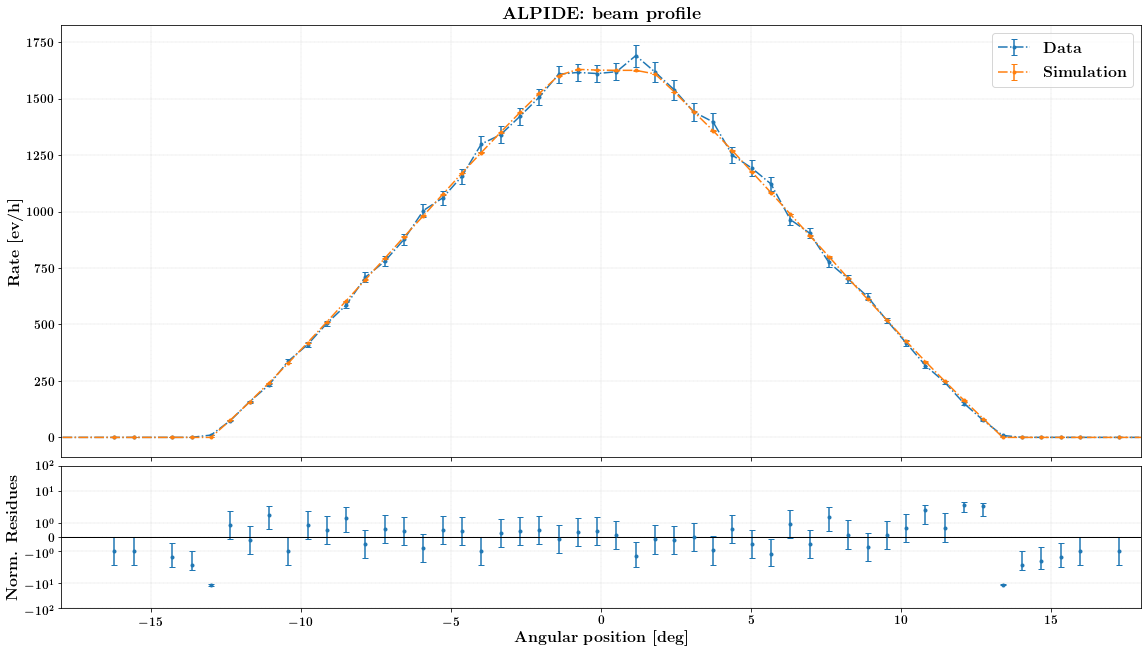

In [16]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(10,6))
plt.axes(axisbelow=True)



#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))

########## ERRORPLOT OF EXPERIMENTAL DATA
plt.errorbar(
    x               = df_exp["ALPIDE_deg"],
    y               = df_exp["ALPIDE_r"],
    yerr            = df_exp["ALPIDE_r_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Data}",
    alpha           = 1
)

########## ERRORPLOT OF SIMULATED DATA
plt.errorbar(
    x               = df_sim["ALPIDE_deg"],
    y               = df_sim["ALPIDE_r"],
    yerr            = df_sim["ALPIDE_r_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Simulation}",
    alpha           = 1
)

########## TOP PANEL SETTINGS
plt.ylabel(r"\bf{Rate [ev/h]}")
plt.title(r"\bf{ALPIDE: beam profile}")
plt.xlim(-18,18)
#plt.xticks(df_exp["ALPIDE_step"][df_exp["ALPIDE_step"] % 3 == 0])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,       # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False  # labels along the bottom edge are off
)
plt.legend()
plt.grid(linestyle='--', linewidth=0.25)
#######################################################################


#######################################################################
##### BOTTOM PANEL
#######################################################################
fig.add_axes((0.,0.,1.0,0.33))

########## ERRORPLOT OF RESIDUES
plt.errorbar(
    x               = df_sim["ALPIDE_deg"],
    y               = res,
    yerr            = np.ones(df_sim.shape[0]),
    fmt             ='o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Residues}",
    alpha           = 1
)

########## ZERO HLINE FOR RESIDUES
plt.axhline(y=0, color="black", linewidth=1)

########## BOTTOM PANEL SETTINGS
plt.xlim(-18,18)
plt.ylim(-100,100)
plt.yscale("symlog")
plt.ylabel(r"\bf{Norm. Residues}")
plt.xlabel(r"\bf{Angular position [deg]}")
#plt.xticks(df_exp["ALPIDE_step"][df_exp["ALPIDE_step"] % 3 == 0])
plt.grid(linestyle='--', linewidth=0.25)
#######################################################################


#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "ALPIDE_beam_profile.pdf", bbox_inches='tight')
#######################################################################


plt.show()
#######################################################################

# Compute $\chi^2$

In [17]:
print("$\chi^2$ = %f" % np.sum(res[8:-8]**2))
print("d.o.f = %f" % len(res[8:-8]))

$\chi^2$ = 37.389657
d.o.f = 40.000000


***

<br>
<br>
<br>
<br>
<br>

***

## Scattering profile plots

## Gold

### Load data

#### Experimental data

In [18]:
df_exp = pd.read_csv(DATA_PATH + "ALPIDE_data_gold.csv")

#### Simulated data: load

In [19]:
df_sim = np.loadtxt(DATA_PATH + "ALPIDE_sim_test_au_cicciona.txt")

#### Simulated data: shift correction

In [20]:
shift       = np.average(df_exp["ALPIDE_step"], weights=df_exp["ALPIDE_r"])
df_sim[:,0] = df_sim[:,0] / 0.9 + shift

#### Simulated data: grouping + normalization

In [21]:
# group simulated data into the experimental data format (group by step)
sim_steps = []
sim_ev    = []
for step in df_exp["ALPIDE_step"]:
    ev = 0
    for i in range(df_sim.shape[0]-1):
        if (step >= df_sim[i,0]) and (step <= df_sim[i+1,0]):
            m  = (df_sim[i+1,1] - df_sim[i,1]) / (df_sim[i+1,0] - df_sim[i,0])
            ev = df_sim[i,1] + m * (step-df_sim[i,0])
            
    sim_steps.append(step)
    sim_ev.append(ev)

sim_steps = np.array(sim_steps)
sim_ev    = np.array(sim_ev)

# normalization
num = np.sum(df_exp["ALPIDE_r"]) # np.mean(df_exp["pico_r"][np.abs(df_exp["pico_step"])<=2])
den = np.sum(sim_ev)           # np.mean(sim_ev[np.abs(sim_steps)<=2])

sim_norm = num / den

#### Simulated data: put in dataframe

In [22]:
d_sim = {
    "ALPIDE_step"     : sim_steps,
    "ALPIDE_rad"      : sim_steps*0.9*(np.pi)/(180),
    "ALPIDE_deg"      : sim_steps*0.9,
    # "pico_seg"      : pico_seg,
    "ALPIDE_ev"       : sim_ev,
    # "pico_t"        : pico_t,
    "ALPIDE_r"        : sim_ev * sim_norm,
    # "pico_step_err" : pico_step_err,
    # "pico_rad_err"  : pico_rad_err,
    # "pico_deg_err"  : pico_deg_err,
    "ALPIDE_ev_err"   : np.sqrt(sim_ev),
    "ALPIDE_r_err"    : np.sqrt(sim_ev) * sim_norm
}

df_sim = pd.DataFrame(data=d_sim)
df_sim = df_sim.sort_values(by=['ALPIDE_step'])

### Compute residues

In [23]:
res_num =                   df_sim["ALPIDE_r"]      -           df_exp["ALPIDE_r"]
res_den = np.sqrt(np.square(df_sim["ALPIDE_r_err"]) + np.square(df_exp["ALPIDE_r_err"]))
res     = res_num  / res_den

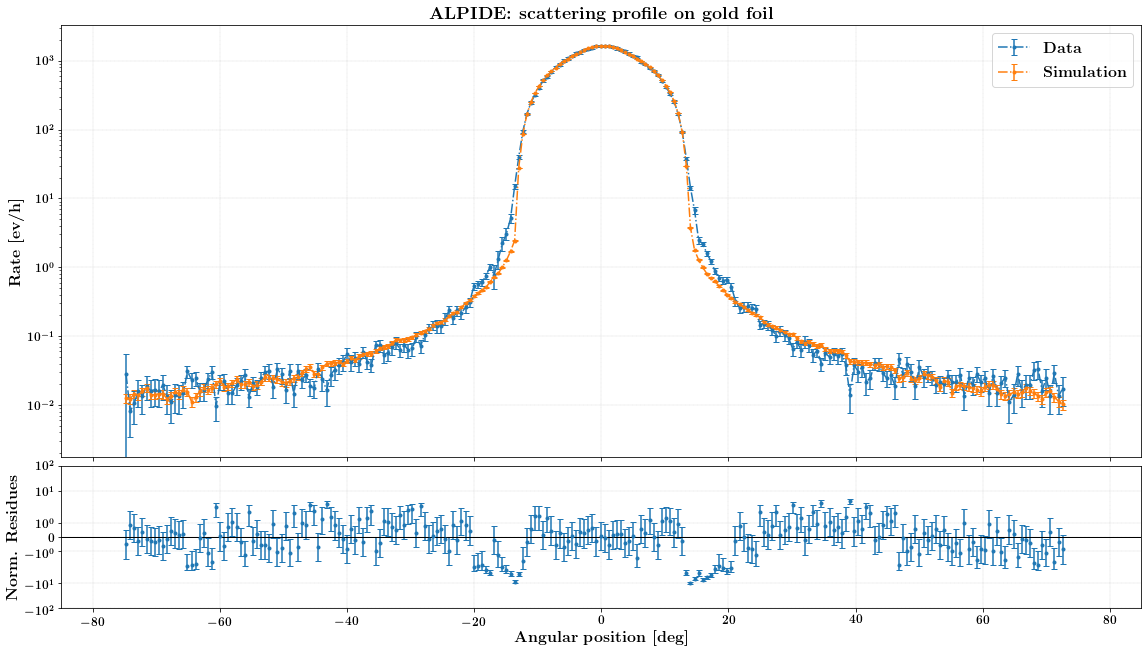

In [24]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(15,6))
plt.axes(axisbelow=True)



#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))

########## ERRORPLOT OF EXPERIMENTAL DATA
plt.errorbar(
    x               = df_exp["ALPIDE_deg"],
    y               = df_exp["ALPIDE_r"],
    yerr            = df_exp["ALPIDE_r_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Data}",
    alpha           = 1
)

########## ERRORPLOT OF SIMULATED DATA
plt.errorbar(
    x               = df_sim["ALPIDE_deg"],
    y               = df_sim["ALPIDE_r"],
    yerr            = df_sim["ALPIDE_r_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Simulation}",
    alpha           = 1
)

########## TOP PANEL SETTINGS
plt.yscale("log")
plt.ylabel(r"\bf{Rate [ev/h]}")
plt.title(r"\bf{ALPIDE: scattering profile on gold foil}")
plt.xlim(-85,85)
#plt.xticks(df_exp["ALPIDE_step"][df_exp["ALPIDE_step"] % 10 == 0])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,       # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False  # labels along the bottom edge are off
)
plt.legend()
plt.grid(linestyle='--', linewidth=0.25)
#######################################################################


#######################################################################
##### BOTTOM PANEL
#######################################################################
fig.add_axes((0.,0.,1.0,0.33))

########## ERRORPLOT OF RESIDUES
plt.errorbar(
    x               = df_sim["ALPIDE_deg"],
    y               = res,
    yerr            = np.ones(df_sim.shape[0]),
    fmt             ='o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Residues}",
    alpha           = 1
)

########## ZERO HLINE FOR RESIDUES
plt.axhline(y=0, color="black", linewidth=1)

########## BOTTOM PANEL SETTINGS
plt.xlim(-85,85)
plt.ylim(-100,100)
plt.yscale("symlog")
plt.ylabel(r"\bf{Norm. Residues}")
plt.xlabel(r"\bf{Angular position [deg]}")
#plt.xticks(df_exp["ALPIDE_step"][df_exp["ALPIDE_step"] % 10 == 0])
plt.grid(linestyle='--', linewidth=0.25)
#######################################################################


#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "ALPIDE_gold_scattering_profile.pdf", bbox_inches='tight')
#######################################################################


plt.show()
#######################################################################

# Compute $\chi^2$

In [25]:
mask_l = np.logical_and(df_exp["ALPIDE_step"] < -30, np.abs(res) < 1000)
mask_r = np.logical_and(df_exp["ALPIDE_step"] >  30, np.abs(res) < 1000)

res_masked_l = res[mask_l]
res_masked_r = res[mask_r]


print("$\chi$   = %f"   % np.sum(np.abs(res_masked_l)))
print("$\chi^2$ = %f" % np.sum(np.square(res_masked_l)))
print("d.o.f    = %f" % len(res_masked_l))

print("$\chi$   = %f"   % np.sum(np.abs(res_masked_r)))
print("$\chi^2$ = %f" % np.sum(np.square(res_masked_r)))
print("d.o.f    = %f" % len(res_masked_r))

print("$\chi$   = %f"   % np.sum(np.abs(res)))
print("$\chi^2$ = %f" % np.sum(np.square(res)))
print("d.o.f    = %f" % len(res))

$\chi$   = 69.145056
$\chi^2$ = 100.523952
d.o.f    = 75.000000
$\chi$   = 68.568676
$\chi^2$ = 107.127584
d.o.f    = 71.000000
$\chi$   = 269.601124
$\chi^2$ = 756.358535
d.o.f    = 230.000000


Dn,m 0.05479968877259195
Crit bound:  0.05558339475307323
1194.0000032420733
-30.195222895949453


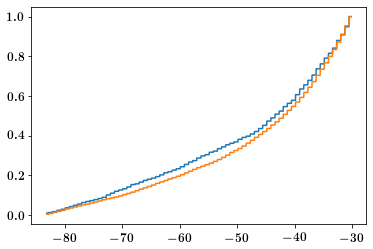

In [26]:
x_sim_left = df_sim[df_sim["ALPIDE_step"]<-30]["ALPIDE_step"]
y_sim_left = np.cumsum(df_sim[df_sim["ALPIDE_step"]<-30]["ALPIDE_r"])

x_dat_left = df_exp[df_exp["ALPIDE_step"]<-30]["ALPIDE_step"]
y_dat_left = np.cumsum(df_exp[df_exp["ALPIDE_step"]<-30]["ALPIDE_r"])


#k_n = tot_sim  * np.sum(y_sim_left)/np.sum(alpide_sim/norm)
#k_m = tot_data * np.sum(y_dat_left)/np.sum(counts_hratio_norm)
k_m = np.sum(df_exp[df_exp["ALPIDE_step"]<-30]["ALPIDE_ev"])



def left_data(xs):
    x = []
    for d in xs:
        x.append(y_dat_left[np.argmin(np.abs(x_dat_left-d))]/np.max(y_dat_left))
    return np.array(x)

def left_sim(xs):
    x = []
    for d in xs:
        x.append(y_sim_left[np.argmin(np.abs(x_sim_left-d))]/np.max(y_sim_left))
    return np.array(x)

x= np.linspace(max(np.min(x_sim_left), np.min(x_dat_left)),
                  min(np.max(x_sim_left), np.max(x_dat_left)), 2000)

#plt.plot(x_sim_left, y_sim_left/np.max(y_sim_left))
#plt.plot(x_dat_left, y_dat_left/np.max(y_dat_left))
plt.plot(x, left_data(x))
plt.plot(x, left_sim(x))

dist = np.abs(np.max(np.abs(left_data(x)-left_sim(x))))

alpha = 0.05
crit_value = np.sqrt(-np.log(alpha/2)*(1/k_m))#(1+k_m/k_n)/(2*k_m))

print("Dn,m", dist)
print("Crit bound: ", crit_value)
#print(k_n, k_m)
print(k_m)

print(max(np.max(x_sim_left), np.max(x_dat_left)))

In [27]:
df_gold = pd.read_csv(DATA_PATH + "ALPIDE_data_gold.csv")
df_tin  = pd.read_csv(DATA_PATH + "ALPIDE_data_tin.csv")
df_beam = pd.read_csv(DATA_PATH + "ALPIDE_data_profile.csv")

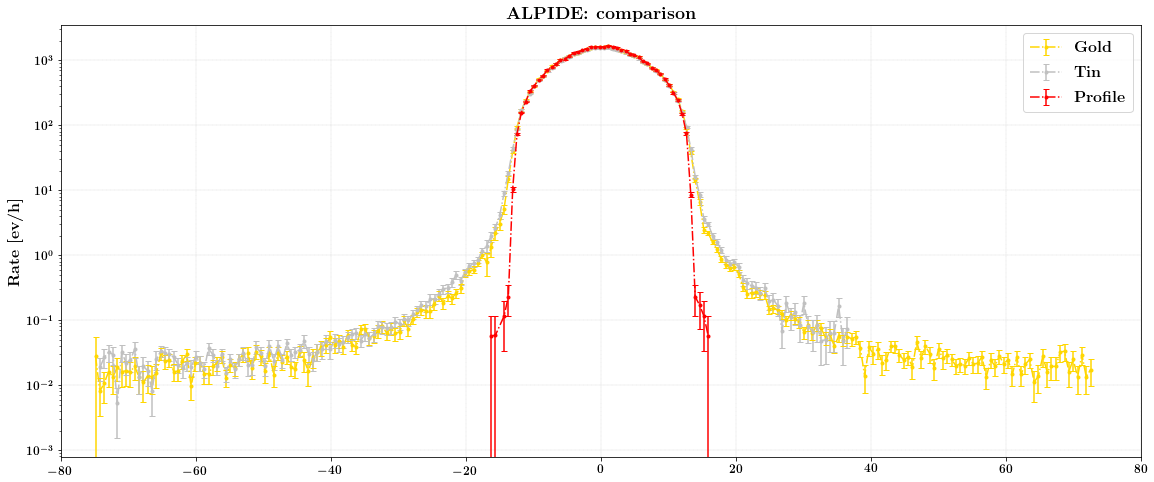

In [28]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(15,6))



#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))

########## ERRORPLOT OF EXPERIMENTAL DATA

plt.errorbar(
    x               = df_gold["ALPIDE_deg"],
    y               = df_gold["ALPIDE_r"],
    yerr            = df_gold["ALPIDE_r_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    color           = 'gold',
    label           = r"\bf{Gold}",
    alpha           = 1
)

plt.errorbar(
    x               = df_tin["ALPIDE_deg"],
    y               = df_tin["ALPIDE_r"],
    yerr            = df_tin["ALPIDE_r_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    color           = 'silver',
    label           = r"\bf{Tin}",
    alpha           = 1
)

plt.errorbar(
    x               = df_beam["ALPIDE_deg"][3:-3],
    y               = df_beam["ALPIDE_r"][3:-3],
    yerr            = df_beam["ALPIDE_r_err"][3:-3],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    color           = 'red',
    label           = r"\bf{Profile}",
    alpha           = 1
)

########## TOP PANEL SETTINGS
plt.yscale("log")
plt.ylabel(r"\bf{Rate [ev/h]}")
plt.title(r"\bf{ALPIDE: comparison}")
plt.xlim(-80,80)

plt.legend()
plt.grid(linestyle='--', linewidth=0.25)


plt.show()

In [29]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

In [30]:
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

<ipython-input-30-4c3d034b1475>:1: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\boldmath']


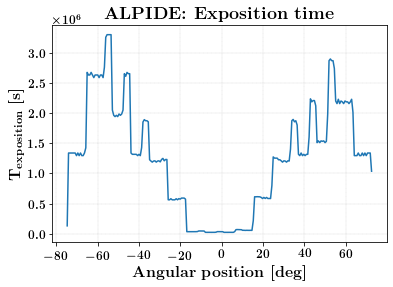

In [31]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(6,4))

plt.errorbar(
    x               = df_gold["ALPIDE_deg"],
    y               = df_gold["ALPIDE_t"],
    fmt             ='-',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Data}",
    alpha           = 1
)

plt.title(r"\bf{ALPIDE: Exposition time}")
plt.ylabel(r"\bf{$\mathrm{T_{\mathrm{exposition}}}$ [s]}")
plt.xlabel(r"\bf{Angular position [deg]}")
#plt.xticks(df_exp["ALPIDE_step"][df_exp["ALPIDE_step"] % 10 == 0])
plt.grid(linestyle='--', linewidth=0.25)

#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "ALPIDE_gold_scattering_time.pdf", bbox_inches='tight')
#######################################################################


plt.show()
#######################################################################

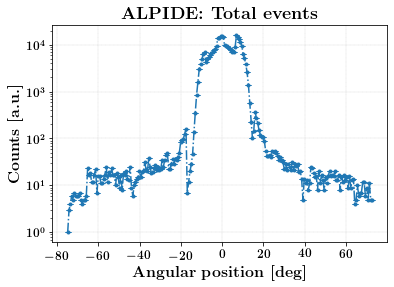

In [32]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(6,4))

plt.errorbar(
    x               = df_gold["ALPIDE_deg"],
    y               = df_gold["ALPIDE_ev"],
    yerr            = df_gold["ALPIDE_ev_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Data}",
    alpha           = 1
)

plt.title(r"\bf{ALPIDE: Total events}")
plt.yscale("log")
plt.ylabel(r"\bf{Counts [a.u.]}")
plt.xlabel(r"\bf{Angular position [deg]}")
#plt.xticks(df_exp["ALPIDE_step"][df_exp["ALPIDE_step"] % 10 == 0])
plt.grid(linestyle='--', linewidth=0.25)

#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "ALPIDE_gold_scattering_counts.pdf", bbox_inches='tight')
#######################################################################


plt.show()
#######################################################################

***

<br>
<br>
<br>
<br>
<br>

***

## Tin

In [33]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

In [34]:
df_exp = pd.read_csv(DATA_PATH + "ALPIDE_data_tin.csv")

In [35]:
df_sim = np.loadtxt(DATA_PATH + "ALPIDE_sim2(1).txt")

In [36]:
shift       = np.average(df_exp["ALPIDE_step"], weights=df_exp["ALPIDE_r"])
df_sim[:,0] = df_sim[:,0] / 0.9 + shift

In [37]:
# group simulated data into the experimental data format (group by step)
sim_steps = []
sim_ev    = []
for step in df_exp["ALPIDE_step"]:
    ev = 0
    for i in range(df_sim.shape[0]-1):
        if (step >= df_sim[i,0]) and (step <= df_sim[i+1,0]):
            m  = (df_sim[i+1,1] - df_sim[i,1]) / (df_sim[i+1,0] - df_sim[i,0])
            ev = df_sim[i,1] + m * (step-df_sim[i,0])
            
    sim_steps.append(step)
    sim_ev.append(ev)

sim_steps = np.array(sim_steps)
sim_ev    = np.array(sim_ev)

# normalization
num = np.sum(df_exp["ALPIDE_r"]) # np.mean(df_exp["pico_r"][np.abs(df_exp["pico_step"])<=2])
den = np.sum(sim_ev)           # np.mean(sim_ev[np.abs(sim_steps)<=2])

sim_norm = num / den

In [38]:
d_sim = {
    "ALPIDE_step"     : sim_steps,
    # "pico_rad"      : pico_rad,
    # "pico_deg"      : pico_deg,
    # "pico_seg"      : pico_seg,
    "ALPIDE_ev"       : sim_ev,
    # "pico_t"        : pico_t,
    "ALPIDE_r"        : sim_ev * sim_norm,
    # "pico_step_err" : pico_step_err,
    # "pico_rad_err"  : pico_rad_err,
    # "pico_deg_err"  : pico_deg_err,
    "ALPIDE_ev_err"   : np.sqrt(sim_ev),
    "ALPIDE_r_err"    : np.sqrt(sim_ev) * sim_norm
}

df_sim = pd.DataFrame(data=d_sim)
df_sim = df_sim.sort_values(by=['ALPIDE_step'])

In [39]:
res_num =                   df_sim["ALPIDE_r"]      -           df_exp["ALPIDE_r"]
res_den = np.sqrt(np.square(df_sim["ALPIDE_r_err"]) + np.square(df_exp["ALPIDE_r_err"]))
res     = res_num  / res_den

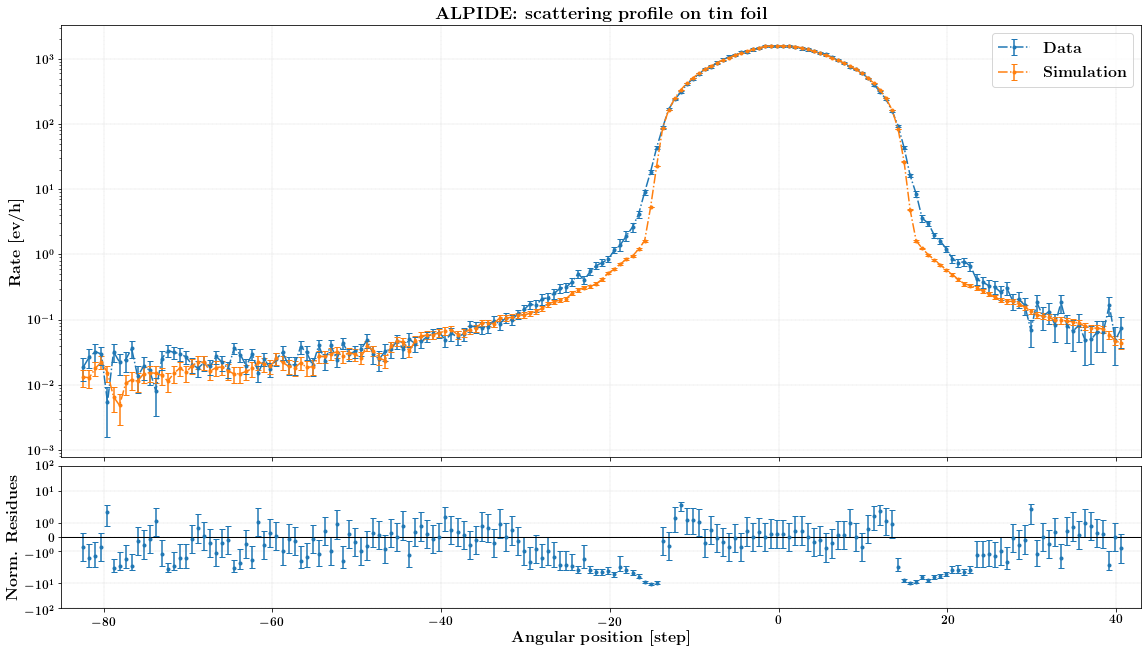

In [40]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(15,6))
plt.axes(axisbelow=True)



#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))

########## ERRORPLOT OF EXPERIMENTAL DATA
plt.errorbar(
    x               = df_exp["ALPIDE_deg"],
    y               = df_exp["ALPIDE_r"],
    yerr            = df_exp["ALPIDE_r_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Data}",
    alpha           = 1
)

########## ERRORPLOT OF SIMULATED DATA
plt.errorbar(
    x               = df_sim["ALPIDE_deg"],
    y               = df_sim["ALPIDE_r"],
    yerr            = df_sim["ALPIDE_r_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Simulation}",
    alpha           = 1
)

########## TOP PANEL SETTINGS
plt.yscale("log")
plt.ylabel(r"\bf{Rate [ev/h]}")
plt.title(r"\bf{ALPIDE: scattering profile on tin foil}")
plt.xlim(-85,43)
#plt.xticks(df_exp["ALPIDE_step"][df_exp["ALPIDE_step"] % 10 == 0])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,       # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False  # labels along the bottom edge are off
)
plt.legend()
plt.grid(linestyle='--', linewidth=0.25)
#######################################################################


#######################################################################
##### BOTTOM PANEL
#######################################################################
fig.add_axes((0.,0.,1.0,0.33))

########## ERRORPLOT OF RESIDUES
plt.errorbar(
    x               = df_sim["ALPIDE_deg"],
    y               = res,
    yerr            = np.ones(df_sim.shape[0]),
    fmt             ='o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Residues}",
    alpha           = 1
)

########## ZERO HLINE FOR RESIDUES
plt.axhline(y=0, color="black", linewidth=1)

########## BOTTOM PANEL SETTINGS
plt.xlim(-85,43)
plt.ylim(-100,100)
plt.yscale("symlog")
plt.ylabel(r"\bf{Norm. Residues}")
plt.xlabel(r"\bf{Angular position [deg]}")
#plt.xticks(df_exp["ALPIDE_step"][df_exp["ALPIDE_step"] % 10 == 0])
plt.grid(linestyle='--', linewidth=0.25)
#######################################################################


#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "ALPIDE_tin_scattering_profile.pdf", bbox_inches='tight')
#######################################################################


plt.show()
#######################################################################

# Compute $\chi^2$

In [41]:
print("$\chi^2$ = %f" % np.sum(res[df_exp["ALPIDE_step"]<-30]**2))
print("d.o.f = %f" % len(res[df_exp["ALPIDE_step"]<-30]))

print("$\chi^2$ = %f" % np.sum(res[df_exp["ALPIDE_step"]>30]**2))
print("d.o.f = %f" % len(res[df_exp["ALPIDE_step"]>30]))

$\chi^2$ = 87.222069
d.o.f = 74.000000
$\chi^2$ = 11.171587
d.o.f = 15.000000


Dn,m 0.07876018876848812
Crit bound:  0.05122176873419666
1406.0000028193494
-30.18482070843


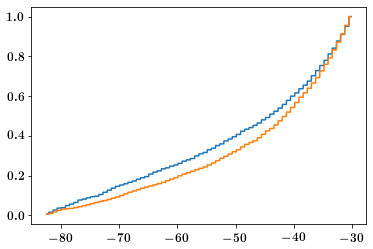

In [42]:
x_sim_left = df_sim[df_sim["ALPIDE_step"]<-30]["ALPIDE_step"]
y_sim_left = np.cumsum(df_sim[df_sim["ALPIDE_step"]<-30]["ALPIDE_r"])

x_dat_left = df_exp[df_exp["ALPIDE_step"]<-30]["ALPIDE_step"]
y_dat_left = np.cumsum(df_exp[df_exp["ALPIDE_step"]<-30]["ALPIDE_r"])


#k_n = tot_sim  * np.sum(y_sim_left)/np.sum(alpide_sim/norm)
#k_m = tot_data * np.sum(y_dat_left)/np.sum(counts_hratio_norm)
k_m = np.sum(df_exp[df_exp["ALPIDE_step"]<-30]["ALPIDE_ev"])



def left_data(xs):
    x = []
    for d in xs:
        x.append(y_dat_left[np.argmin(np.abs(x_dat_left-d))]/np.max(y_dat_left))
    return np.array(x)

def left_sim(xs):
    x = []
    for d in xs:
        x.append(y_sim_left[np.argmin(np.abs(x_sim_left-d))]/np.max(y_sim_left))
    return np.array(x)

x= np.linspace(max(np.min(x_sim_left), np.min(x_dat_left)),
                  min(np.max(x_sim_left), np.max(x_dat_left)), 2000)

#plt.plot(x_sim_left, y_sim_left/np.max(y_sim_left))
#plt.plot(x_dat_left, y_dat_left/np.max(y_dat_left))
plt.plot(x, left_data(x))
plt.plot(x, left_sim(x))

dist = np.abs(np.max(np.abs(left_data(x)-left_sim(x))))

alpha = 0.05
crit_value = np.sqrt(-np.log(alpha/2)*(1/k_m))#(1+k_m/k_n)/(2*k_m))

print("Dn,m", dist)
print("Crit bound: ", crit_value)
#print(k_n, k_m)
print(k_m)

print(max(np.max(x_sim_left), np.max(x_dat_left)))

In [43]:
df_exp = pd.read_csv(DATA_PATH + "ALPIDE_Strobe_gap.csv")

In [44]:
d = {
    "Strobe"     : [5000],
    "Gap"        : [25000],
    "Str_par"    : [1/6],
    "Ev"         : [3221],
    "Rate"       : [192660],
    "Rate_err"   : [3405]
}

df_app = pd.DataFrame(data=d)

In [45]:
df_exp = df_exp.append(df_app, ignore_index=True)

In [46]:
from scipy.optimize import curve_fit
def linear(x,a,b):
    return a+b*x

popt, pcov = curve_fit(linear, xdata=df_exp["Str_par"], ydata=df_exp["Rate"], sigma=df_exp["Rate_err"])

In [47]:
res_num = linear(df_exp["Str_par"],popt[0],popt[1])  -  df_exp["Rate"]
res_den = df_exp["Rate_err"]
res     = res_num  / res_den

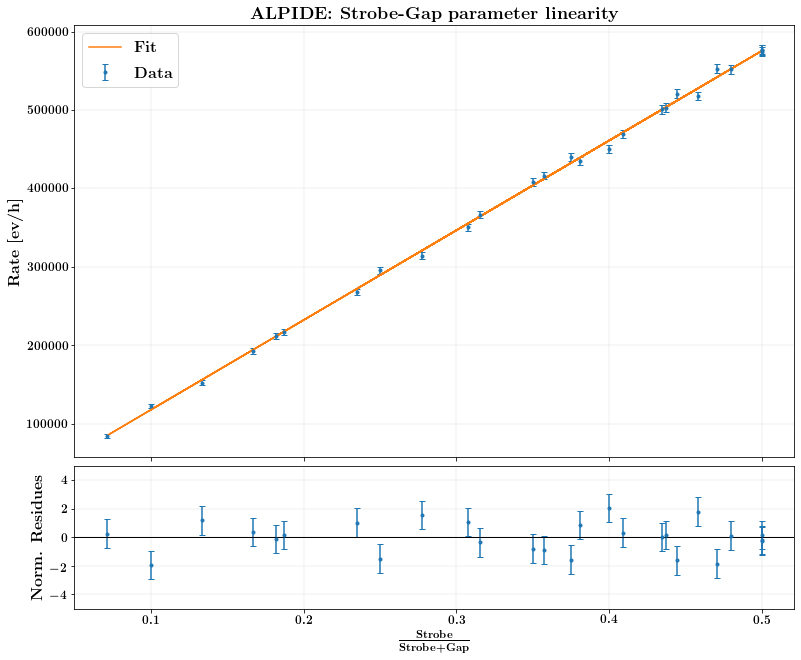

In [48]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(10,6))



#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))

########## ERRORPLOT OF EXPERIMENTAL DATA
plt.errorbar(
    x               = df_exp["Str_par"],
    y               = df_exp["Rate"],
    yerr            = df_exp["Rate_err"],
    fmt             ='o',
    markersize      = 3,
    capsize         = 3,
    label           = r"\bf{Data}",
    alpha           = 1
)

########## PLOT OF WEIGHTED AVERAGE HLINE
plt.plot(
    df_exp["Str_par"],
    linear(df_exp["Str_par"],popt[0],popt[1]),
    linewidth = 1.5,
    label     = r"\bf{Fit}"
)

########## TOP PANEL SETTINGS
# plt.ylim(np.max(df_exp["pico_r"])*0.0, np.max(df_exp["pico_r"])*1.5)
plt.ylabel(r"\bf{Rate [ev/h]}")
plt.title(r"\bf{ALPIDE: Strobe-Gap parameter linearity}")
#plt.xlim(-40,40)
#plt.xticks(df_exp["pico_deg"][df_exp["pico_deg"] % 9 == 0])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.legend()
plt.grid(linestyle='--', linewidth=0.25, zorder=0)
#######################################################################


#######################################################################
##### BOTTOM PANEL
#######################################################################
fig.add_axes((0.,0.,1.0,0.33))

########## ERRORPLOT OF RESIDUES
plt.errorbar(
    x               = df_exp["Str_par"],
    y               = res,
    yerr            = np.ones(df_exp.shape[0]),
    fmt             ='o',
    markersize      = 3,
    capsize         = 3,
    # markerfacecolor = "red",
    # color           = "red",
    # ecolor          = "red",
    label           = r"\bf{Norm. Residues}",
    alpha           = 1
)

########## ZERO HLINE FOR RESIDUES
plt.axhline(y=0, color="black", linewidth=1)

########## BOTTOM PANEL SETTINGS
plt.ylim(-5,5)
plt.ylabel(r"\bf{Norm. Residues}")
plt.xlabel(r"\bf{$\mathrm{\frac{Strobe}{Strobe+Gap}}$")
#plt.xticks(df_exp["pico_deg"][df_exp["pico_deg"] % 9 == 0])
plt.grid(linestyle='--', linewidth=0.25, zorder=0)
#######################################################################


#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "ALPIDE_str_par.pdf", bbox_inches='tight')
#######################################################################


plt.show()
#######################################################################

# Compute $\chi^2$

In [49]:
print("$\chi^2$ = %f" % np.sum(res**2))
print("d.o.f = %f"    % (len(res)-2))

$\chi^2$ = 30.894553
d.o.f = 24.000000


## Cluster hitmap

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors

In [51]:
#Folder_name = "bkg_24h_151220"
Folder_name = "gold_alpide_53_SC_240m_run9_020121"

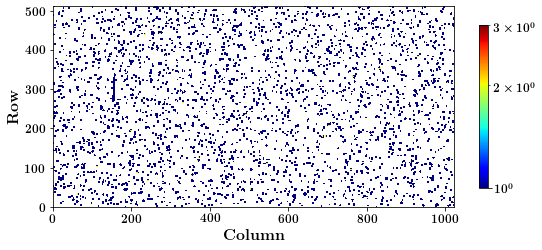

In [52]:
#plot it
cluster_matrix = np.loadtxt(DATA_PATH + "Cluster_matrix_" + Folder_name + ".csv", dtype=np.int16)

fig, ax = plt.subplots(figsize=(9,6))

colormap = cm.get_cmap('jet')
psm = ax.pcolormesh(cluster_matrix, cmap=colormap, norm=colors.LogNorm(vmin=1))

cbar = plt.colorbar(psm, shrink=0.5, ax=ax)
## cbar.set_label("N. hits")

plt.axis('scaled')
ax.set(xlim=(0, 1023), ylim=(0, 511))
plt.xlabel(r"\bf{Column}")
plt.ylabel(r"\bf{Row}")


String = SAVE_PATH + "ALPIDE_" + Folder_name + '_hitmap.pdf'
plt.savefig(String, bbox_inches='tight')
plt.show()

In [53]:
col = palette.Category20[10]

## Threshold analysis

In [77]:
df        = pd.read_csv (DATA_PATH + "ALPIDE_THR.csv"     )
Area_arr  = np.load     (DATA_PATH + "ALPIDE_area_box.npy", allow_pickle=True)
PCAr_arr  = np.load     (DATA_PATH + "ALPIDE_PCA_box.npy" , allow_pickle=True)
VCASN_val = np.load     (DATA_PATH + "ALPIDE_VCASN.npy"   , allow_pickle=True)

## SNR plot

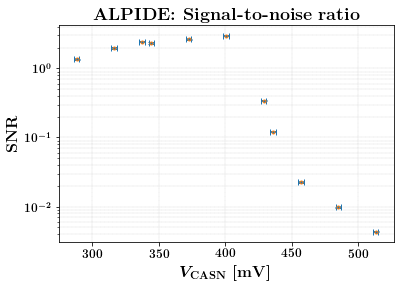

In [61]:
plt.figure(figsize=(6,4))
plt.yscale("log")
plt.errorbar(df["VCASN_val"]*df["DAC_unit"],
             df["SNR"],
             xerr            = df["VCASN_err"],
             yerr            = df["SNR_err"],
             fmt             = 'o',
             markerfacecolor = col[0],
             color           = col[2],
             ecolor          = col[0],
             label           = r"\bf{data}",
             alpha           = 1,
             markersize      = 3,
             capsize         = 3
             ) #fillstyle="none"

plt.title (r"\bf{ALPIDE: Signal-to-noise ratio}")
plt.xlabel(r"\bf{$V_{\mathrm{CASN}}$ [mV]}")
plt.ylabel(r"\bf{SNR}")

plt.grid(True, linestyle='--',linewidth=0.25, zorder=-1, which="both")
#plt.legend()
fig.savefig(SAVE_PATH + "ALPIDE_SNR_graph_py.pdf", bbox_inches='tight')
plt.show()

## Area plot

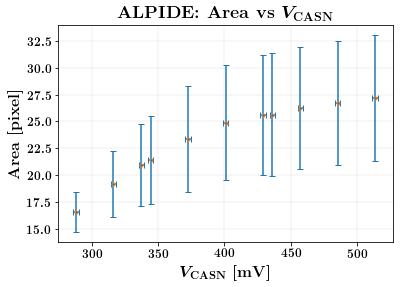

In [62]:
plt.figure(figsize=(6,4))
#plt.yscale("log")
plt.errorbar(df["VCASN_val"]*df["DAC_unit"],
             df["Mean_area"],
             xerr            = df["VCASN_err"],
             yerr            = df["Area_err"],
             fmt             = 'o',
             markerfacecolor = col[0],
             color           = col[2],
             ecolor          = col[0],
             label           = r"\bf{data}",
             alpha           = 1,
             markersize      = 3,
             capsize         = 3) #fillstyle="none"

plt.title (r"\bf{ALPIDE: Area vs $V_{\mathrm{CASN}}$")
plt.xlabel(r"\bf{$V_{\mathrm{CASN}}$ [mV]}")
plt.ylabel(r"\bf{Area [pixel]}")


plt.grid(True, linestyle='--',linewidth=0.25, zorder=-1)
#plt.legend()
fig.savefig(SAVE_PATH + "ALPIDE_Area_graph_py.pdf", bbox_inches='tight')
plt.show()

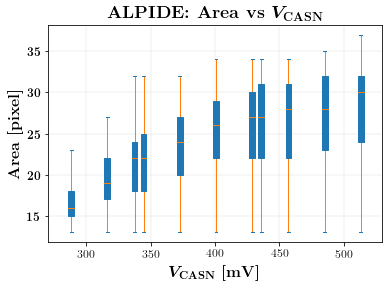

In [79]:
plt.figure(figsize=(6,4))

for i in range(len(df["VCASN_val"])):
    bp = plt.boxplot(Area_arr[i],
                patch_artist=True,
                sym       = '',
                positions = [VCASN_val[i]*df["DAC_unit"][i]],
                widths    = [4.5],
                whis      = 3
               )
    
    plt.setp(bp['boxes']   , color=col[0])
    plt.setp(bp['whiskers'], color=col[2])
    plt.setp(bp['caps']    , color=col[0])

plt.xticks(range(250,600,50), labels=range(250,600,50))
plt.xlim([270,530])

plt.title (r"\bf{ALPIDE: Area vs $V_{\mathrm{CASN}}$")
plt.xlabel(r"\bf{$V_{\mathrm{CASN}}$ [mV]}")
plt.ylabel(r"\bf{Area [pixel]}")

plt.grid(True, linestyle='--',linewidth=0.25, zorder=-1)
fig.savefig(SAVE_PATH + "ALPIDE_Area_graph_py_box.pdf", bbox_inches='tight')
plt.show()

## PCA plot

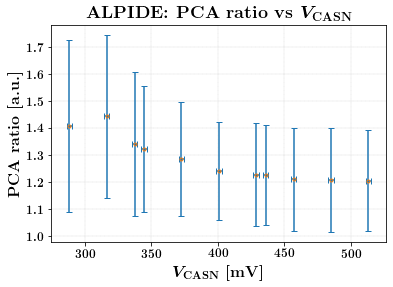

In [81]:
plt.figure(figsize=(6,4))
#plt.yscale("log")
plt.errorbar(df["VCASN_val"]*df["DAC_unit"],
             df["Mean_PCAr"],
             xerr            = df["VCASN_err"],
             yerr            = df["PCAr_err"],
             fmt             = 'o',
             markerfacecolor = col[0],
             color           = col[2],
             ecolor          = col[0],
             label           = r"\bf{data}",
             alpha           = 1,
             markersize      = 3,
             capsize         = 3) #fillstyle="none"

plt.title (r"\bf{ALPIDE: PCA ratio vs $V_{\mathrm{CASN}}$")
plt.xlabel(r"\bf{$V_{\mathrm{CASN}}$ [mV]}")
plt.ylabel(r"\bf{PCA ratio [a.u.]}")

plt.grid(True, linestyle='--',linewidth=0.25, zorder=-1)
#plt.legend()
fig.savefig(SAVE_PATH + "ALPIDE_PCAr_graph_py.pdf", bbox_inches='tight')
plt.show()

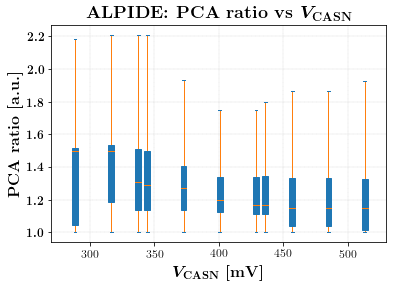

In [82]:
plt.figure(figsize=(6,4))

for i in range(len(df["VCASN_val"])):
    bp = plt.boxplot(PCAr_arr[i],
                patch_artist=True,
                sym       = '',
                positions = [VCASN_val[i]*df["DAC_unit"][i]],
                widths    = [4.5],
                whis      = 2
               )
    
    plt.setp(bp['boxes']   , color=col[0])
    plt.setp(bp['whiskers'], color=col[2])
    plt.setp(bp['caps']    , color=col[0])
    plt.setp(bp['medians'] , color=col[2])

plt.xticks(range(250,600,50), labels=range(250,600,50))
plt.xlim([270,530])

plt.title (r"\bf{ALPIDE: PCA ratio vs $V_{\mathrm{CASN}}$")
plt.xlabel(r"\bf{$V_{\mathrm{CASN}}$ [mV]}")
plt.ylabel(r"\bf{PCA ratio [a.u.]}")

plt.grid(True, linestyle='--',linewidth=0.25, zorder=-1)
fig.savefig(SAVE_PATH + "ALPIDE_PCAr_graph_py_box.pdf", bbox_inches='tight')
plt.show()

## Cosmic rays

In [83]:
df_exp = pd.read_csv(DATA_PATH + "ALPIDE_Cosmic.csv")

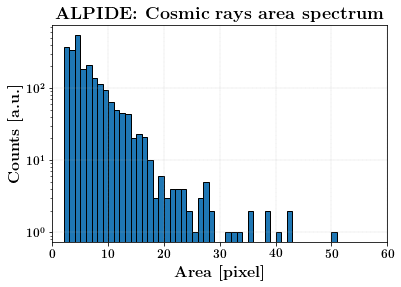

In [84]:
plt.figure(figsize=(6,4))
plt.yscale("log")
plt.hist(df_exp["Areas_C"],
         bins      = int(max(df_exp["Areas_C"])-min(df_exp["Areas_C"])),
         edgecolor = 'black',
         color     = col[0]
        ) #fillstyle="none"

plt.title (r"\bf{ALPIDE: Cosmic rays area spectrum}")
plt.xlabel(r"\bf{Area [pixel]}")
plt.ylabel(r"\bf{Counts [a.u.]}")
plt.xlim(0,60)

plt.grid(True, linestyle='--',linewidth=0.25, zorder=-1)
#plt.legend()
fig.savefig(SAVE_PATH + "ALPIDE_Cosmic_Area_hist_py_box.pdf", bbox_inches='tight')
plt.show()

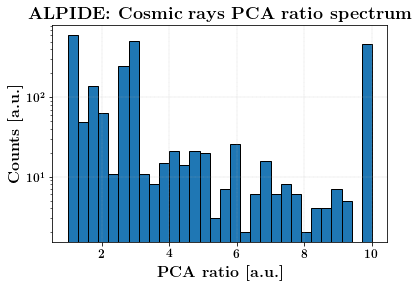

In [85]:
plt.figure(figsize=(6,4))
plt.yscale("log")
plt.hist(df_exp["Ratios_C"],
         bins      = 30,
         edgecolor = 'black',
         color     = col[0]
        ) #fillstyle="none"

plt.title (r"\bf{ALPIDE: Cosmic rays PCA ratio spectrum}")
plt.xlabel(r"\bf{PCA ratio [a.u.]}")
plt.ylabel(r"\bf{Counts [a.u.]}")

plt.grid(True, linestyle='--',linewidth=0.25, zorder=-1)
#plt.legend()
fig.savefig(SAVE_PATH + "ALPIDE_Cosmic_PCA_hist_py_box.pdf", bbox_inches='tight')
plt.show()

## X rays

In [91]:
df_exp = pd.read_csv(DATA_PATH + "ALPIDE_Xrays.csv")

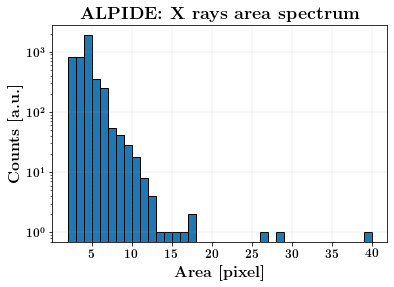

In [92]:
plt.figure(figsize=(6,4))
plt.yscale("log")
plt.hist(df_exp["Areas_X"],
         bins      = int(max(df_exp["Areas_X"])-min(df_exp["Areas_X"])),
         edgecolor = 'black',
         color     = col[0]
        ) #fillstyle="none"

plt.title (r"\bf{ALPIDE: X rays area spectrum}")
plt.xlabel(r"\bf{Area [pixel]}")
plt.ylabel(r"\bf{Counts [a.u.]}")

plt.grid(True, linestyle='--',linewidth=0.25, zorder=-1)
#plt.legend()
fig.savefig(SAVE_PATH + "ALPIDE_Cosmic_hist_py_box.pdf", bbox_inches='tight')
plt.show()

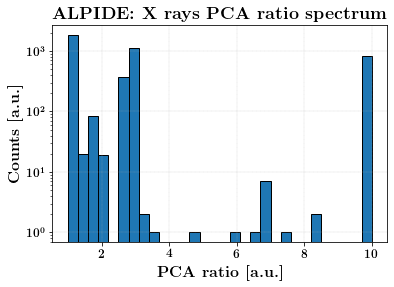

In [93]:
plt.figure(figsize=(6,4))
plt.yscale("log")
plt.hist(df_exp["Ratios_X"],
         bins  = 30,
         edgecolor = 'black',
         color     = col[0]
        ) #fillstyle="none"

plt.title (r"\bf{ALPIDE: X rays PCA ratio spectrum}")
plt.xlabel(r"\bf{PCA ratio [a.u.]}")
plt.ylabel(r"\bf{Counts [a.u.]}")

plt.grid(True, linestyle='--',linewidth=0.25, zorder=-1)
#plt.legend()
fig.savefig(SAVE_PATH + "ALPIDE_X_PCA_hist_py_box.pdf", bbox_inches='tight')
plt.show()

## Alpha particles

In [99]:
df_exp = pd.read_csv(DATA_PATH + "ALPIDE_Alpha.csv")
df_disc = pd.read_csv(DATA_PATH + "ALPIDE_Alpha_disc.csv")

,Areas_disc_A,Ratios_disc_A
0,26.0,1.139375
1,26.0,1.139375
2,19.0,1.666053
3,26.0,1.267645
4,24.0,1.354473
...,...,...
163958,28.0,1.037647
163959,24.0,1.195219
163960,23.0,1.172949
163961,29.0,1.235422


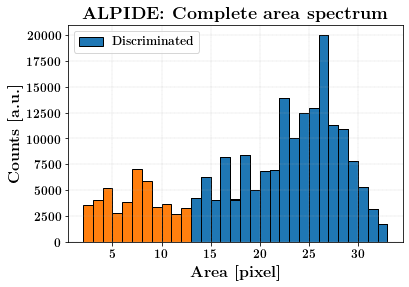

In [97]:
plt.figure(figsize=(6,4))
#plt.yscale("log")

plt.hist(df_disc["Areas_disc_A"],
         bins      = int(max(df_exp["Areas_A"])-min(df_exp["Areas_A"])),
         range     = (int(min(df_exp["Areas_A"])),int(max(df_exp["Areas_A"]))),
         edgecolor = 'black',
         label     = r'\bf{Discriminated}',
         zorder    = 1,
         #alpha     = 0.25,
         color     = col[0]
        ) #fillstyle="none"

plt.hist(df_exp["Areas_A"],
         bins      = int(max(df_exp["Areas_A"])-min(df_exp["Areas_A"])),
         range     = (int(min(df_exp["Areas_A"])),int(max(df_exp["Areas_A"]))),
         edgecolor = 'black',
         #label     = r'\bf{Complete}',
         zorder    = 0,
         #alpha     = 0.75,
         color     = col[2]
        ) #fillstyle="none"

plt.title (r"\bf{ALPIDE: Complete area spectrum}")
plt.xlabel(r"\bf{Area [pixel]}")
plt.ylabel(r"\bf{Counts [a.u.]}")

plt.grid(True, linestyle='--',linewidth=0.25, zorder=-1)
plt.legend(fontsize=12)
fig.savefig(SAVE_PATH + "ALPIDE_Alpha_Area_hist_py_box.pdf", bbox_inches='tight')
plt.show()

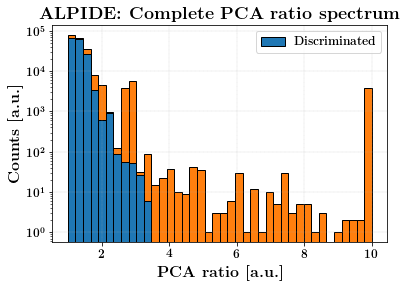

In [100]:
plt.figure(figsize=(6,4))
plt.yscale("log")

plt.hist(df_disc["Ratios_disc_A"],
         bins      = 40,
         range     = (int(min(df_exp["Ratios_A"])),int(max(df_exp["Ratios_A"]))),
         edgecolor = 'black',
         #alpha     = 0.75,
         label     = r'\bf{Discriminated}',
         zorder    = 1,
         color     = col[0]
        ) #fillstyle="none"

plt.hist(df_exp["Ratios_A"],
         bins      = 40,
         range     = (int(min(df_exp["Ratios_A"])),int(max(df_exp["Ratios_A"]))),
         edgecolor = 'black',
         #label     = r'\bf{Complete}',
         zorder    = 0,
         color     = col[2]
        ) #fillstyle="none"

plt.title (r"\bf{ALPIDE: Complete PCA ratio spectrum}")
plt.xlabel(r"\bf{PCA ratio [a.u.]}")
plt.ylabel(r"\bf{Counts [a.u.]}")

plt.grid(True, linestyle='--',linewidth=0.25, zorder=-1)
plt.legend(fontsize=12)
fig.savefig(SAVE_PATH + "ALPIDE_Alpha_PCA_hist_py_box.pdf", bbox_inches='tight')
plt.show()